In [1]:
import geopandas as gpd
from shapely.geometry import Point, shape
import matplotlib.pyplot as plt

import preprocessing.downloader as dl

ids = dl.fetch_ids_on_envirocar(num_trajectories=10)

10
['64c2bce5c7e42807e7b87a42', '64c2b669c7e42807e7b8797a', '64c29fd8c7e42807e7b83193', '64c29f90c7e42807e7b8312a', '64c28d5fc7e42807e7b823c5', '64c28a19c7e42807e7b81568', '64c2869dc7e42807e7b7f4ea', '64c2852cc7e42807e7b7f0dc', '64c28340c7e42807e7b7eb20', '64c27edfc7e42807e7b7df2f']


In [2]:
%%time

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

def mean_interval_between_adjacent_points(gdf):
    """
    Compute the mean of intervals between two adjacent points in a GeoDataFrame.

    Parameters:
        gdf (geopandas.GeoDataFrame): The input GeoDataFrame.

    Returns:
        float: Mean interval between adjacent points.
    """
    # Shift the geometry column to get the next point's geometry
    gdf['next_geometry'] = gdf['geometry'].shift(-1)

    # Compute the distance between each point and the next point
    gdf['distance'] = gdf['geometry'].distance(gdf['next_geometry'])

    # Compute the mean of the distances
    mean_distance = gdf['distance'].mean()

    # Remove the temporary columns
    gdf.drop(columns=['next_geometry', 'distance'], inplace=True)

    return mean_distance

def make_noise(mean, std_dev, magnitude, min_noise):
    while True:
        noise = np.random.normal(loc=mean, scale=std_dev) * magnitude
        if noise >= min_noise:
            return noise

def perturbate_selected_rows(gdf, perturbation_percentage=0.05, mean=0, std_dev=1, label_column='label'):
    """
    Perturbate selected rows in a GeoDataFrame.

    Parameters:
        gdf (geopandas.GeoDataFrame): The input GeoDataFrame.
        perturbation_percentage (float): The percentage of rows to perturbate.
        mean (float): Mean of the normal distribution for perturbation.
        std_dev (float): Standard deviation of the normal distribution for perturbation.
        label_column (str): The column name that contains the label (1 for selected, 0 for not selected).

    Returns:
        geopandas.GeoDataFrame: A new GeoDataFrame with perturbated selected rows.
    """
    #gdf = gdf.copy()
    # Step 1: Calculate the number of rows to randomly pick
    num_rows_to_pick = int(len(gdf) * perturbation_percentage)
    
    # print('# of selected points: ', num_rows_to_pick)

    # Step 2: Randomly select the subset of rows
    random_subset = gdf.sample(n=num_rows_to_pick, random_state=42)

    # Step 3: Add labels to the randomly selected rows
    # For the selected rows, set the label to 1; otherwise, set it to 0
    gdf[label_column] = np.where(gdf.index.isin(random_subset.index), 1, 0)

    # Step 4: Perturbate only the selected rows
    selected_rows = gdf[gdf[label_column] == 1].copy()  # Make a copy to avoid SettingWithCopyWarning
    mean_interval = mean_interval_between_adjacent_points(gdf)
    # I'm not sure if these parameters are ok
    noise_magnitude = mean_interval * 6
    min_noise = mean_interval * 2
    
    # Loop through each selected point and apply noise
    for _, row in selected_rows.iterrows():
        # Generate noise with minimum standard deviation
        noise_x = make_noise(mean, std_dev, noise_magnitude, min_noise)
        noise_y = make_noise(mean, std_dev, noise_magnitude, min_noise)
        
        # Apply noise to the point
        row['geometry'] = Point(row['geometry'].x + noise_x, row['geometry'].y + noise_y)
        
        # Update the modified row back to the DataFrame
        selected_rows.at[_, 'geometry'] = row['geometry']
    
    # Create a new GeoDataFrame by combining perturbated selected rows with unselected rows
    perturbated_gdf = pd.concat([selected_rows, gdf[gdf[label_column] == 0]])

    # Return the new GeoDataFrame with perturbated selected rows
    return gpd.GeoDataFrame(perturbated_gdf, geometry='geometry')

valid_ids = []
perturbated_gdfs = []

pd.set_option('display.max_columns',None)

for idx, id in enumerate(ids):
        gdf = dl.download_from_envirocar(id)

        if gdf is None or len(gdf) < 200:
            continue
#         perturbated_gdf = perturbate_selected_rows(gdf, perturbation_percentage=0.05, mean=0, std_dev=1, label_column = 'noise')
#         valid_ids.append(id)
#         perturbated_gdfs.append(perturbated_gdf)
# print(len(valid_ids)) threhold

{'CO2 Emission (GPS-based)': {'value': 1.9578514186892255, 'unit': 'kg/h'}, 'Minimum GPS Acceleration': {'value': 0.2598650327227024, 'unit': 'm/s²'}, 'Consumption (GPS-based)': {'value': 0.8331282632720108, 'unit': 'l/h'}, 'GPS Accuracy': {'value': 9.935046492071336, 'unit': '%'}, 'GPS Bearing': {'value': 253.8994316145563, 'unit': 'deg'}, 'GPS Altitude': {'value': 301.6171254074179, 'unit': 'm'}, 'Maximum GPS Acceleration': {'value': 0.2598650327227024, 'unit': 'm/s²'}, 'GPS Speed': {'value': 16.217531706733325, 'unit': 'km/h'}}
{'GPS Altitude': {'value': 350.89654996925964, 'unit': 'm'}, 'CO2 Emission (GPS-based)': {'value': 5.866439734236923, 'unit': 'kg/h'}, 'Consumption (GPS-based)': {'value': 2.4963573337178397, 'unit': 'l/h'}, 'GPS HDOP': {'value': 49.81498900055885, 'unit': 'precision'}, 'GPS VDOP': {'value': 50.21814480423927, 'unit': 'precision'}, 'GPS Speed': {'value': 54.830474853515625, 'unit': 'km/h'}, 'GPS Accuracy': {'value': 32.0, 'unit': '%'}, 'GPS PDOP': {'value': 7

In [3]:
%%time

import warnings
warnings.simplefilter("error")

import dask
import dask.bag as db

import preprocessing.dbscan as ds

def sigle_outlier_detection_experiment(slope, id, perturbated_gdf):
    # perturbated_gdf = perturbate_selected_rows(gdf, perturbation_percentage=0.05, mean=0, std_dev=1, label_column = 'noise')
    eliminated_gdf = ds.eliminate_outliers(perturbated_gdf, slope, min_samples=3).drop('cluster', axis=1)

    # Perform the spatial difference overlay operation
    difference_gdf = perturbated_gdf.overlay(eliminated_gdf, how='difference')
    eliminated_outliers_gdf = difference_gdf[difference_gdf['noise'] == 1]
    eliminated_nonoutliers_gdf = difference_gdf[difference_gdf['noise'] == 0]
    
    return (slope, id, len(perturbated_gdf[perturbated_gdf['noise'] == 1]), len(eliminated_outliers_gdf), len(perturbated_gdf[perturbated_gdf['noise'] == 0]), len(eliminated_nonoutliers_gdf))

fineness = 360
num_trajectories = len(valid_ids)

total_outliers = np.zeros((fineness, num_trajectories))
eliminated_outliers = np.zeros((fineness, num_trajectories))
nonoutliers = np.zeros((fineness, num_trajectories))
eliminated_nonoutliers = np.zeros((fineness, num_trajectories))
done_ids = np.full((fineness, num_trajectories), '')

outlier_detection_results = []

for i in tqdm(range(0, fineness)):
    # print(['i', i])
    slope = 90 * i / fineness
    for j in range(num_trajectories):
        id = valid_ids[j]
        perturbated_gdf = perturbated_gdfs[j]
        outlier_detection_results.append(dask.delayed(sigle_outlier_detection_experiment)(slope, id, perturbated_gdf))

  0%|          | 0/360 [00:00<?, ?it/s]

CPU times: user 506 ms, sys: 79.1 ms, total: 585 ms
Wall time: 699 ms


In [4]:
%%time

from dask.diagnostics import ProgressBar

with ProgressBar():
    outlier_detection_results = dask.compute(*outlier_detection_results, scheduler='processes')

CPU times: user 770 µs, sys: 1.52 ms, total: 2.29 ms
Wall time: 4.76 ms


In [5]:
%%time

slope_to_index = {}
for i in tqdm(range(0, fineness)):
    slope = 90 * i / fineness
    slope_to_index[slope] = i

id_to_index = {}
for i, id in enumerate(valid_ids):
    id_to_index[id] = i

total_outliers = np.zeros((fineness, num_trajectories))
eliminated_outliers = np.zeros((fineness, num_trajectories))
total_nonoutliers = np.zeros((fineness, num_trajectories))
eliminated_nonoutliers = np.zeros((fineness, num_trajectories))
done_ids = np.full((fineness, num_trajectories), '')

for outlier_detection_result in outlier_detection_results:
    slope, id, num_total_outliers, num_eliminated_outliers, num_total_nonoutliers, num_eliminated_nonoutliers = outlier_detection_result
    
    i = slope_to_index[slope]
    j = id_to_index[id]
    total_outliers[i, j] = num_total_outliers
    eliminated_outliers[i, j] = num_eliminated_outliers
    total_nonoutliers[i, j] = num_total_nonoutliers
    eliminated_nonoutliers[i, j] = num_eliminated_nonoutliers
    done_ids[i, j] = valid_ids[j]

  0%|          | 0/360 [00:00<?, ?it/s]

CPU times: user 8.68 ms, sys: 597 µs, total: 9.28 ms
Wall time: 8.31 ms


In the following code, we download GPS traces from Open Street Map, cluster it by using the DBSCAN algorithm, and then plot the result.

  0%|          | 0/360 [00:00<?, ?it/s]

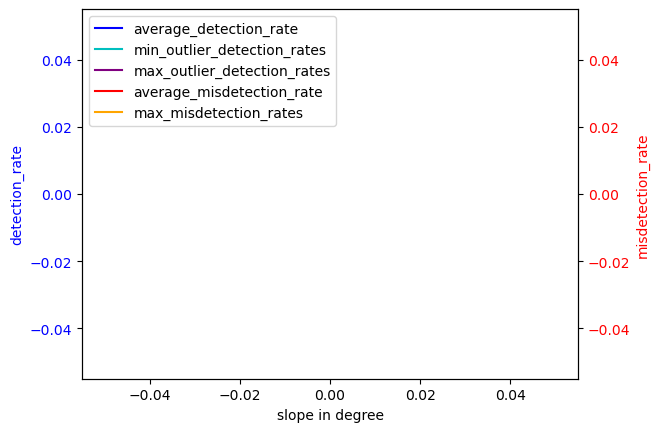

[]
CPU times: user 199 ms, sys: 150 ms, total: 349 ms
Wall time: 173 ms


In [6]:
%%time

def average_outlier_detection_rate(total_outliers, detected_outliers):
    sum_outlier_detection_rate = 0
    counter = 0
    for i in range(len(total_outliers)):
        if total_outliers[i] > 0:
            sum_outlier_detection_rate += detected_outliers[i] / total_outliers[i]
            counter += 1
    if counter == 0:
        return -1
    return sum_outlier_detection_rate / counter

def max_detection_rate(total_outliers, detected_outliers):
    result = 0
    for i in range(len(total_outliers)):
        if total_outliers[i] > 0:
            result = max(result, detected_outliers[i] / total_outliers[i])
    return result

def min_detection_rate(total_outliers, detected_outliers):
    result = 1
    for i in range(len(total_outliers)):
        if total_outliers[i] > 0:
            result = min(result, detected_outliers[i] / total_outliers[i])
    return result

def average_misdetection_rate(total_nonoutliers, misdetected_nonoutliers):
    sum_misdetected_nonoutliers_rate = 0
    counter = 0
    for i in range(len(total_nonoutliers)):
        if total_nonoutliers[i] > 0:
            sum_misdetected_nonoutliers_rate += misdetected_nonoutliers[i] / total_nonoutliers[i]
            counter += 1
    if counter == 0:
        return -1
    return sum_misdetected_nonoutliers_rate / counter

def max_misdetection_rate(total_nonoutliers, misdetected_nonoutliers):
    result = 0
    for i in range(len(total_nonoutliers)):
        if total_nonoutliers[i] > 0:
            result = max(result, misdetected_nonoutliers[i] / total_nonoutliers[i])
    return result

detection_rates_x = []
detection_rates_y = []
max_outlier_detection_rates_x = []
max_outlier_detection_rates_y = []
min_outlier_detection_rates_x = []
min_outlier_detection_rates_y = []
misdetection_rates_x = []
misdetection_rates_y = []
max_misdetection_rates_x = []
max_misdetection_rates_y = []

for i in tqdm(range(0, fineness)):
    slope = 90 * i / fineness
    detection_rate = average_outlier_detection_rate(total_outliers[i], eliminated_outliers[i])
    if detection_rate != -1:
        detection_rates_x.append(slope)
        detection_rates_y.append(detection_rate)
        min_outlier_detection_rates_x.append(slope)
        min_outlier_detection_rates_y.append(min_detection_rate(total_outliers[i], eliminated_outliers[i]))
        max_outlier_detection_rates_x.append(slope)
        max_outlier_detection_rates_y.append(max_detection_rate(total_outliers[i], eliminated_outliers[i]))
    
    misdetection_rate = average_misdetection_rate(total_nonoutliers[i], eliminated_nonoutliers[i])
    if misdetection_rate != -1:
        misdetection_rates_x.append(slope)
        misdetection_rates_y.append(misdetection_rate)
        max_misdetection_rates_x.append(slope)
        max_misdetection_rates_y.append(max_misdetection_rate(total_nonoutliers[i], eliminated_nonoutliers[i]))
# Create a new figure
fig, ax1 = plt.subplots()

# Plot the first list with its own Y-axis
ax1.plot(detection_rates_x, detection_rates_y, color='b', label='average_detection_rate')
ax1.plot(min_outlier_detection_rates_x, min_outlier_detection_rates_y, color='c', label='min_outlier_detection_rates')
ax1.plot(max_outlier_detection_rates_x, max_outlier_detection_rates_y, color='purple', label='max_outlier_detection_rates')
ax1.set_xlabel('slope in degree')
ax1.set_ylabel('detection_rate', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary Y-axis for the second list
ax2 = ax1.twinx()

# Plot the second list with its own Y-axis
plt.plot(misdetection_rates_x, misdetection_rates_y, color='r', label='average_misdetection_rate')
plt.plot(max_misdetection_rates_x, max_misdetection_rates_y, color='orange', label='max_misdetection_rates')
ax2.set_ylabel('misdetection_rate', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legends for both lists
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

print(max_misdetection_rates_y)

In [7]:
# import importlib
# importlib.reload(ds)

for i in range(0, fineness, 40):
    slope = 90 * i / fineness
    gdf_idx = np.argmin([a / b if b > 0 else 1 for (a, b) in zip(eliminated_outliers[i], total_outliers[i])])
    perturbated_gdf = perturbated_gdfs[gdf_idx]
    print(['slope', slope])
    print(['id', id])
    ds.visualize_outlier_detection(perturbated_gdf, slope, min_samples=3)

ValueError: attempt to get argmin of an empty sequence

In [ ]:
import xml.etree.ElementTree as ET
import importlib

import preprocessing.plotter as plotter

latest_id = 8000000  # 8487896
num_of_retrieved_traces = 32
slope = 45
for i in tqdm(range(num_of_retrieved_traces)):
    # Down load a GPS trace from Open Street Map
    id = latest_id - i
    gdf = dl.load_GPStrace_from_OSM(id)
    if gdf is None:
        print(f"skipped {url}")
        continue
        
    # Compute the points for the k-NN distance plot
    k = 3
    knn_distances = []
    for i in range(len(gdf)):
        knn_distances.append(ds.knn_distance(gdf, i, k))
    sorted_knn_distances = sorted(knn_distances)
    x = range(len(sorted_knn_distances))

    # The degree for polynomial fitting
    degree = 9

    # Find the "elbows" in the skewed graph
    minimals_x, minimals_y = ds.skewed_minimals(
        x, sorted_knn_distances, len(x), max(sorted_knn_distances), degree, slope=slope
    )

    # Plot the skwewed data
    ds.plot_skewed(
        x,
        sorted_knn_distances,
        len(x),
        max(sorted_knn_distances),
        degree,
        slope=slope
    )

    # Plot the original data
    plt.scatter(x, sorted_knn_distances, label="Sorted K-NN distances")
    plt.xlabel("Sorted indexes")
    plt.ylabel("K-NN distance")
    plt.title(
        "Plot of pairs of (index, K-NN distance) by the ascending order of K-NN distance"
    )
    plt.grid(True)
    ds.draw_polynomial_fitting(
        x, sorted_knn_distances, degree
    )  # Draw the polynomial fitting for the original data
    plt.scatter(
        minimals_x,
        minimals_y,
        s=40,
        color="Magenta",
        label="Elbows obtained by the polyfit for the skewed data",
    )
    plt.legend()
    plt.show()


    # Clustering
    # eps = min_distance(gdf) * 1.5
    # if eps == 0.0:
    #     eps = max_distance(gdf) / (
    #         2 * len(gdf)
    #     )  # this is kind of random, but I want to avoid eps being 0.0 anyway
    eps = 0.00000000000002
    gdf["cluster"] = ds.trajectory_DBSCAN(
        gdf, eps=eps, min_samples=3
    )
    
    print(gdf["cluster"])
   

    # Plot
    plotter.plot_trajectory(
        gdf,
        f"A GPS trace from OSM (id = {id})",
        plot_trajectory_edges=False,
        plot_clusters=True,
    )

In [ ]:
importlib.reload(plotter)
importlib.reload(dl)
importlib.reload(ds)

# Download trajectory data from envirocar
id = "52f3836be4b0d8e8c27ed6f0"
gdf = dl.download_from_envirocar(id)
slope = 45

#### Mitigate stay points

# Plot the detected elbows
ds.plot_elbow_detection(gdf, slope=slope)

# Before clustering
# This part is just to visualize how the points will be clustered. 
eps_candidates = ds.DBSCAN_eps_candidates(gdf, slope=slope)
eps = eps_candidates[0]
min_samples = 6 #4
gdf["cluster"] = ds.trajectory_DBSCAN(
        gdf, eps=eps, min_samples=min_samples
    )
plotter.plot_trajectory(gdf, "Before mitigating stay points", plot_clusters=True)

# Clustering
gdf = ds.mitigate_stay_points(gdf, slope=slope)

# After clustering
plotter.plot_trajectory(gdf, "After minigating stay points", plot_clusters=True)

### Eliminate
traj_points_num = len(gdf)

# Plot the detected elbows
ds.plot_elbow_detection(gdf, slope=slope)

# Before eliminating outliers
# This part is just to visualize how the points will be clustered. 
eps_candidates = ds.DBSCAN_eps_candidates(gdf, slope=slope)
eps = eps_candidates[-1]
min_samples = 3 #4
gdf["cluster"] = ds.trajectory_DBSCAN(
        gdf, eps=eps, min_samples=min_samples
    )
plotter.plot_trajectory(gdf, "Before eliminating outliers", plot_clusters=True)

# Eliminate outliers
gdf = ds.eliminate_outliers(gdf, min_samples=min_samples, slope=slope)

# After eliminating outliers
plotter.plot_trajectory(gdf, "After eliminating outliers", plot_clusters=False)

print('# of eliminated points', traj_points_num-len(gdf))